#Библиотеки Python для DS (семинары)
##Урок 8. На практике использование методов генерации признаков
В вашем распоряжении набор данных о качестве сна Sleep_health_and_lifestyle_dataset.csv.
Ваша задача — подготовить данные к моделированию, сгенерировать новые признаки, применить методы отбора признаков для улучшения качества предсказательной модели и подобрать оптимальные гиперпараметры для модели регрессии.

1. Предобработка данных:
    - Очистите данные от пропусков и аномалий.
    - Преобразуйте категориальные переменные с помощью One-Hot Encoding или Label Encoding.

2. Генерация новых признаков:
    - Создайте комбинированные признаки, которые могут помочь улучшить модель.
    - Используйте полиномиальные признаки для числовых переменных.

3. Отбор признаков:
    - Примените несколько методов отбора признаков (например, RFE, SelectKBest).
    - Сравните качество модели до и после отбора признаков.

4. Подбор гиперпараметров:
    - Используйте GridSearchCV или RandomizedSearchCV для настройки параметров вашей модели регрессии.
    - Оцените, как изменение гиперпараметров влияет на качество предсказаний.

###1. Предобработка данных:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [47]:
# Загрузка данных
file_path = '/content/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path)

# Первичный анализ данных
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [48]:
df.info()
df.describe(include='all').T.round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Person ID,374.0,NaN,NaN,NaN,187.5,108.108742,1.0,94.25,187.5,280.75,374.0
Gender,374,2,Male,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,374.0,NaN,NaN,NaN,42.184492,8.673133,27.0,35.25,43.0,50.0,59.0
Occupation,374,11,Nurse,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Duration,374.0,NaN,NaN,NaN,7.132086,0.795657,5.8,6.4,7.2,7.8,8.5
Quality of Sleep,374.0,NaN,NaN,NaN,7.312834,1.196956,4.0,6.0,7.0,8.0,9.0
Physical Activity Level,374.0,NaN,NaN,NaN,59.171123,20.830804,30.0,45.0,60.0,75.0,90.0
Stress Level,374.0,NaN,NaN,NaN,5.385027,1.774526,3.0,4.0,5.0,7.0,8.0
BMI Category,374,4,Normal,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blood Pressure,374,25,130/85,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Список значений категориальных параметров

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")
    print('-'*30)

Gender: ['Male' 'Female']
------------------------------
Occupation: ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
------------------------------
BMI Category: ['Overweight' 'Normal' 'Obese' 'Normal Weight']
------------------------------
Blood Pressure: ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95' '139/91'
 '118/75']
------------------------------
Sleep Disorder: [nan 'Sleep Apnea' 'Insomnia']
------------------------------


DataFrame, содержит 374 записи и 13 Признаков. Из них 6 категориальные.

**Категориальные:**
1. Person ID (Идентификатор человека)
2. Gender (Пол)
3. Occupation (Профессия)
4. BMI Category (Категория ИМТ)
5. Blood Pressure (Артериальное давление)
6. Sleep Disorder (Нарушение сна)

**Количественные:**
1. Age (Возраст)
2. Sleep Duration (Продолжительность сна)
3. Quality of Sleep (Качество сна)
4. Physical Activity Level (Уровень физической активности)
5. Stress Level (Уровень стресса)
6. Heart Rate (Пульс)
7. Daily Steps (Ежедневные шаги)


Пропущенных значений нет.

In [50]:
# Заменим "Blood Pressure" на два столбца
new_df = df.copy()
new_df[['Systolic', 'Diastolic']] = new_df['Blood Pressure'].str.split('/', expand=True).astype(int)
new_df = new_df.drop('Blood Pressure', axis=1)
# Удалим Person ID
new_df = new_df.drop('Person ID', axis=1)
# Удалим "Occupation", так как из-за небольшой выборки объективную информацию
#  по професиям из нее невозможно получить
new_df = new_df.drop('Occupation', axis=1)
new_df.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,27,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [51]:
new_df.info()
new_df.describe(include='all').T.round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Sleep Duration           374 non-null    float64
 3   Quality of Sleep         374 non-null    int64  
 4   Physical Activity Level  374 non-null    int64  
 5   Stress Level             374 non-null    int64  
 6   BMI Category             374 non-null    object 
 7   Heart Rate               374 non-null    int64  
 8   Daily Steps              374 non-null    int64  
 9   Sleep Disorder           155 non-null    object 
 10  Systolic                 374 non-null    int64  
 11  Diastolic                374 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 35.2+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,374,2,Male,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,374.0,NaN,NaN,NaN,42.184492,8.673133,27.0,35.25,43.0,50.0,59.0
Sleep Duration,374.0,NaN,NaN,NaN,7.132086,0.795657,5.8,6.4,7.2,7.8,8.5
Quality of Sleep,374.0,NaN,NaN,NaN,7.312834,1.196956,4.0,6.0,7.0,8.0,9.0
Physical Activity Level,374.0,NaN,NaN,NaN,59.171123,20.830804,30.0,45.0,60.0,75.0,90.0
Stress Level,374.0,NaN,NaN,NaN,5.385027,1.774526,3.0,4.0,5.0,7.0,8.0
BMI Category,374,4,Normal,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heart Rate,374.0,NaN,NaN,NaN,70.165775,4.135676,65.0,68.0,70.0,72.0,86.0
Daily Steps,374.0,NaN,NaN,NaN,6816.84492,1617.915679,3000.0,5600.0,7000.0,8000.0,10000.0
Sleep Disorder,155,2,Sleep Apnea,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN


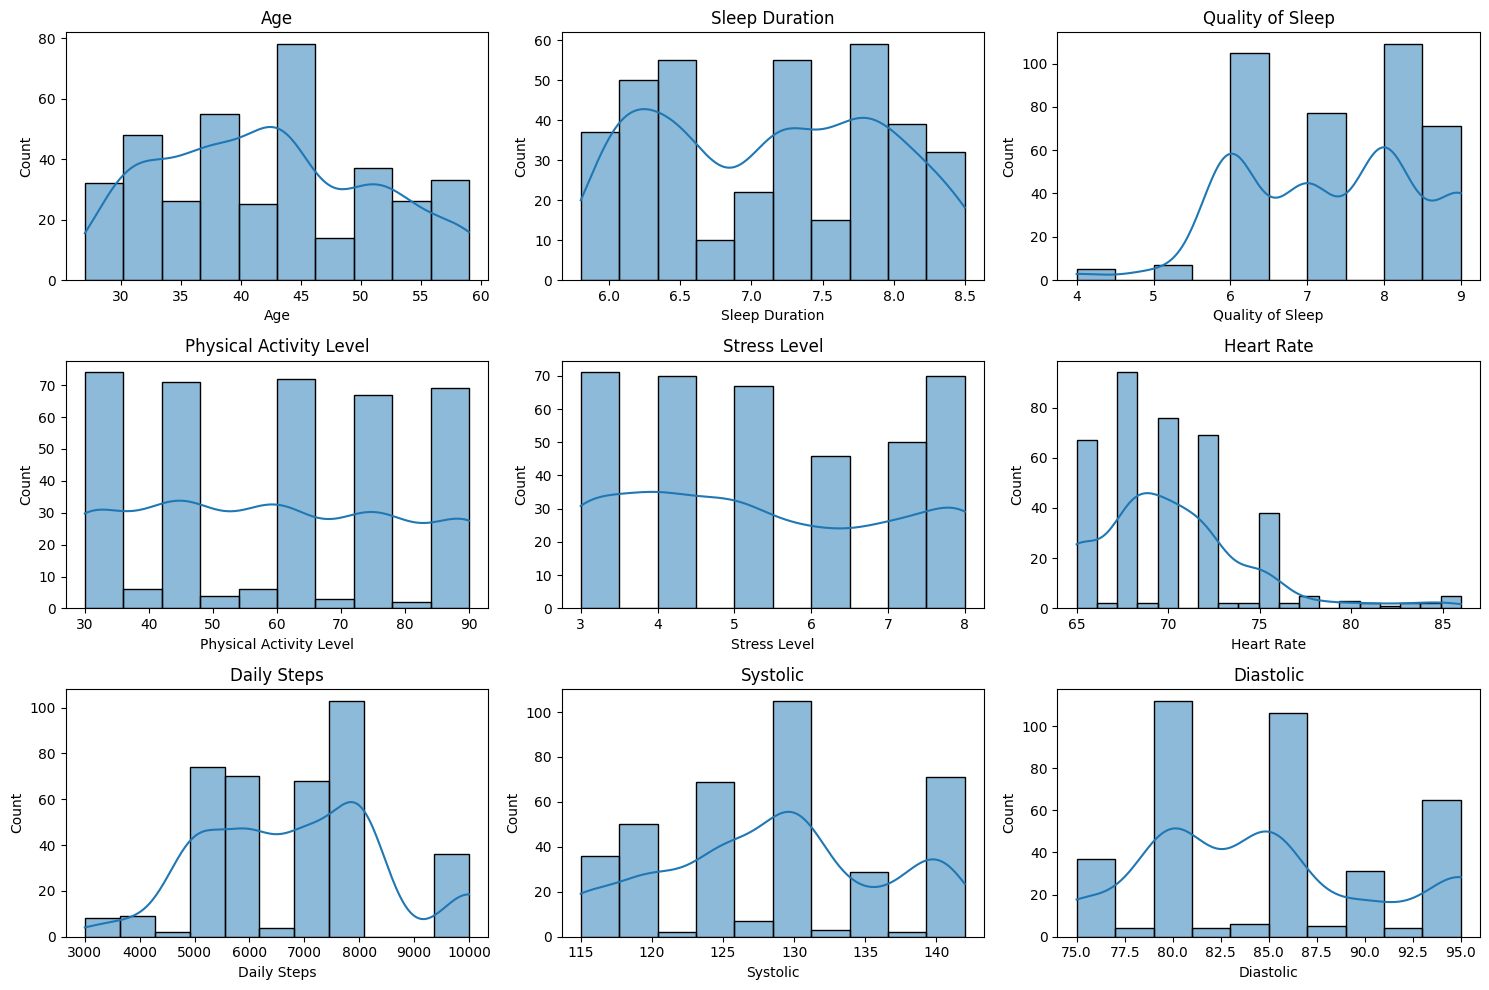

In [52]:
# Выбираем количественные признаки
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep',
                     'Physical Activity Level', 'Stress Level', 'Heart Rate',
                    'Daily Steps','Systolic', 'Diastolic']

# Создаем графики
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(new_df[feature], kde=True)
    plt.title(feature)
    plt.tight_layout()

plt.show()


In [53]:
# Преобразование категориальных переменных с помощью One-Hot Encoding
new_df = pd.get_dummies(new_df, columns=['Gender', 'BMI Category', 'Sleep Disorder'], drop_first=True).astype(int)
new_df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_Sleep Apnea
0,27,6,6,42,6,77,4200,126,83,1,0,0,1,0
1,28,6,6,60,8,75,10000,125,80,1,0,0,0,0
2,28,6,6,60,8,75,10000,125,80,1,0,0,0,0
3,28,5,4,30,8,85,3000,140,90,1,0,1,0,1
4,28,5,4,30,8,85,3000,140,90,1,0,1,0,1


###2. Генерация новых признаков:

In [54]:
# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(new_df[numeric_features])

# Добавление новых признаков
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numeric_features))
data_expanded = pd.concat([new_df.reset_index(drop=True), poly_features_df], axis=1)
data_expanded.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Heart Rate^2,Heart Rate Daily Steps,Heart Rate Systolic,Heart Rate Diastolic,Daily Steps^2,Daily Steps Systolic,Daily Steps Diastolic,Systolic^2,Systolic Diastolic,Diastolic^2
0,27,6,6,42,6,77,4200,126,83,1,...,5929.0,323400.0,9702.0,6391.0,17640000.0,529200.0,348600.0,15876.0,10458.0,6889.0
1,28,6,6,60,8,75,10000,125,80,1,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
2,28,6,6,60,8,75,10000,125,80,1,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
3,28,5,4,30,8,85,3000,140,90,1,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0
4,28,5,4,30,8,85,3000,140,90,1,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0


###3. Отбор признаков:

In [55]:
# Разделение данных на обучающую и тестовую выборки
X = data_expanded.drop('Quality of Sleep', axis=1)
y = data_expanded['Quality of Sleep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели без отбора признаков
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('Без отбора признаков:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Отбор признаков с помощью RFE
selector_rfe = RFE(model, n_features_to_select=10)
selector_rfe.fit(X_train_scaled, y_train)
X_train_rfe = selector_rfe.transform(X_train_scaled)
X_test_rfe = selector_rfe.transform(X_test_scaled)

# Обучение модели с RFE
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
print('\nС отбором признаков (RFE):')
print('MSE:', mean_squared_error(y_test, y_pred_rfe))
print('R2:', r2_score(y_test, y_pred_rfe))

Без отбора признаков:
MSE: 0.0003359999999999975
R2: 0.999777280226255

С отбором признаков (RFE):
MSE: 0.00021733333333333262
R2: 0.9998559391939665


**Вывод:**

Отбор признаков с помощью RFE привел к небольшому, но заметному
улучшению качества модели линейной регрессии. RFE помог исключить из модели признаки, которые не вносили существенного вклада в предсказание качества сна и уменьшил шум в данных.

###4. Подбор гиперпараметров:

In [56]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_rfe, y_train)

# Лучшие параметры и оценка
print('\nЛучшие параметры:', grid_search.best_params_)
print('Лучшая оценка (MSE):', -grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_rfe)
print('\nС лучшими параметрами:')
print('MSE:', mean_squared_error(y_test, y_pred_best))
print('R2:', r2_score(y_test, y_pred_best))



Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Лучшая оценка (MSE): 0.0010481906779661045

С лучшими параметрами:
MSE: 0.0001516666666666673
R2: 0.9998994667687957


**Вывод:**

Подбор гиперпараметров с помощью GridSearchCV позволил найти
оптимальные настройки для модели, что привело к еще большему
улучшению качества предсказаний.